<a href="https://colab.research.google.com/github/rachit2005/Large-Language-Model/blob/main/makemore_trigraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import requests

url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"
resp = requests.get(url)

words = resp.text.splitlines()
print(words[:5])

['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [14]:
min_word_len , max_word_len = min(len(w) for w in words) , max(len(w) for w in words)
print(min_word_len , max_word_len)

2 15


In [15]:
# in this we wil take two characters to predict the third one
b = {}

for w in words:
  chs = ['.'] + list(w) + ['.']

  for ch1 , ch2 , ch3 in zip(chs , chs[1:] , chs[2:]):
    # print(ch1 , ch2 , ch3)
    trigraph = (ch1 , ch2 , ch3)
    b[trigraph] = b.get(trigraph , 0) + 1


# sorted(b.items() , key = lambda kv : -kv[1])

In [28]:
# vocabulary

chars = sorted(list(set(''.join(words))))

stoi = {ch : i+1 for i , ch in enumerate(chars)}
stoi['.'] = 0
itos = {value : key for key , value in stoi.items()}
vocab_size = len(chars)+1


print("string to index: " , stoi.items())
print(f"index to string: " , itos.items())
print(vocab_size)

string to index:  dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])
index to string:  dict_items([(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j'), (11, 'k'), (12, 'l'), (13, 'm'), (14, 'n'), (15, 'o'), (16, 'p'), (17, 'q'), (18, 'r'), (19, 's'), (20, 't'), (21, 'u'), (22, 'v'), (23, 'w'), (24, 'x'), (25, 'y'), (26, 'z'), (0, '.')])
27


In [20]:
def encode(s) : return [stoi[c] for c in s]
def decode(list_of_idx): return ''.join([itos[i] for i in list_of_idx])

In [23]:
# building the trigraph dataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt


X = []
Y = []

for w in words:
  chs = ['.'] + list(w) + ['.']

  for ch1 , ch2 , ch3 in zip(chs , chs[1:] , chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    X.append([ix1 , ix2])
    Y.append(ix3)

X = torch.tensor(X)
Y = torch.tensor(Y)

num = X.nelement()
print(num)

392226


In [30]:
N = torch.zeros((vocab_size , vocab_size , vocab_size) , dtype=torch.int32)

In [32]:
for w in words:
  chs = ['.'] + list(w) + ['.']

  for ch1 ,ch2 , ch3 in zip(chs , chs[1:] , chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    N[ix1 , ix2 , ix3] += 1

In [38]:
X.shape , Y.shape

(torch.Size([196113, 2]), torch.Size([196113]))

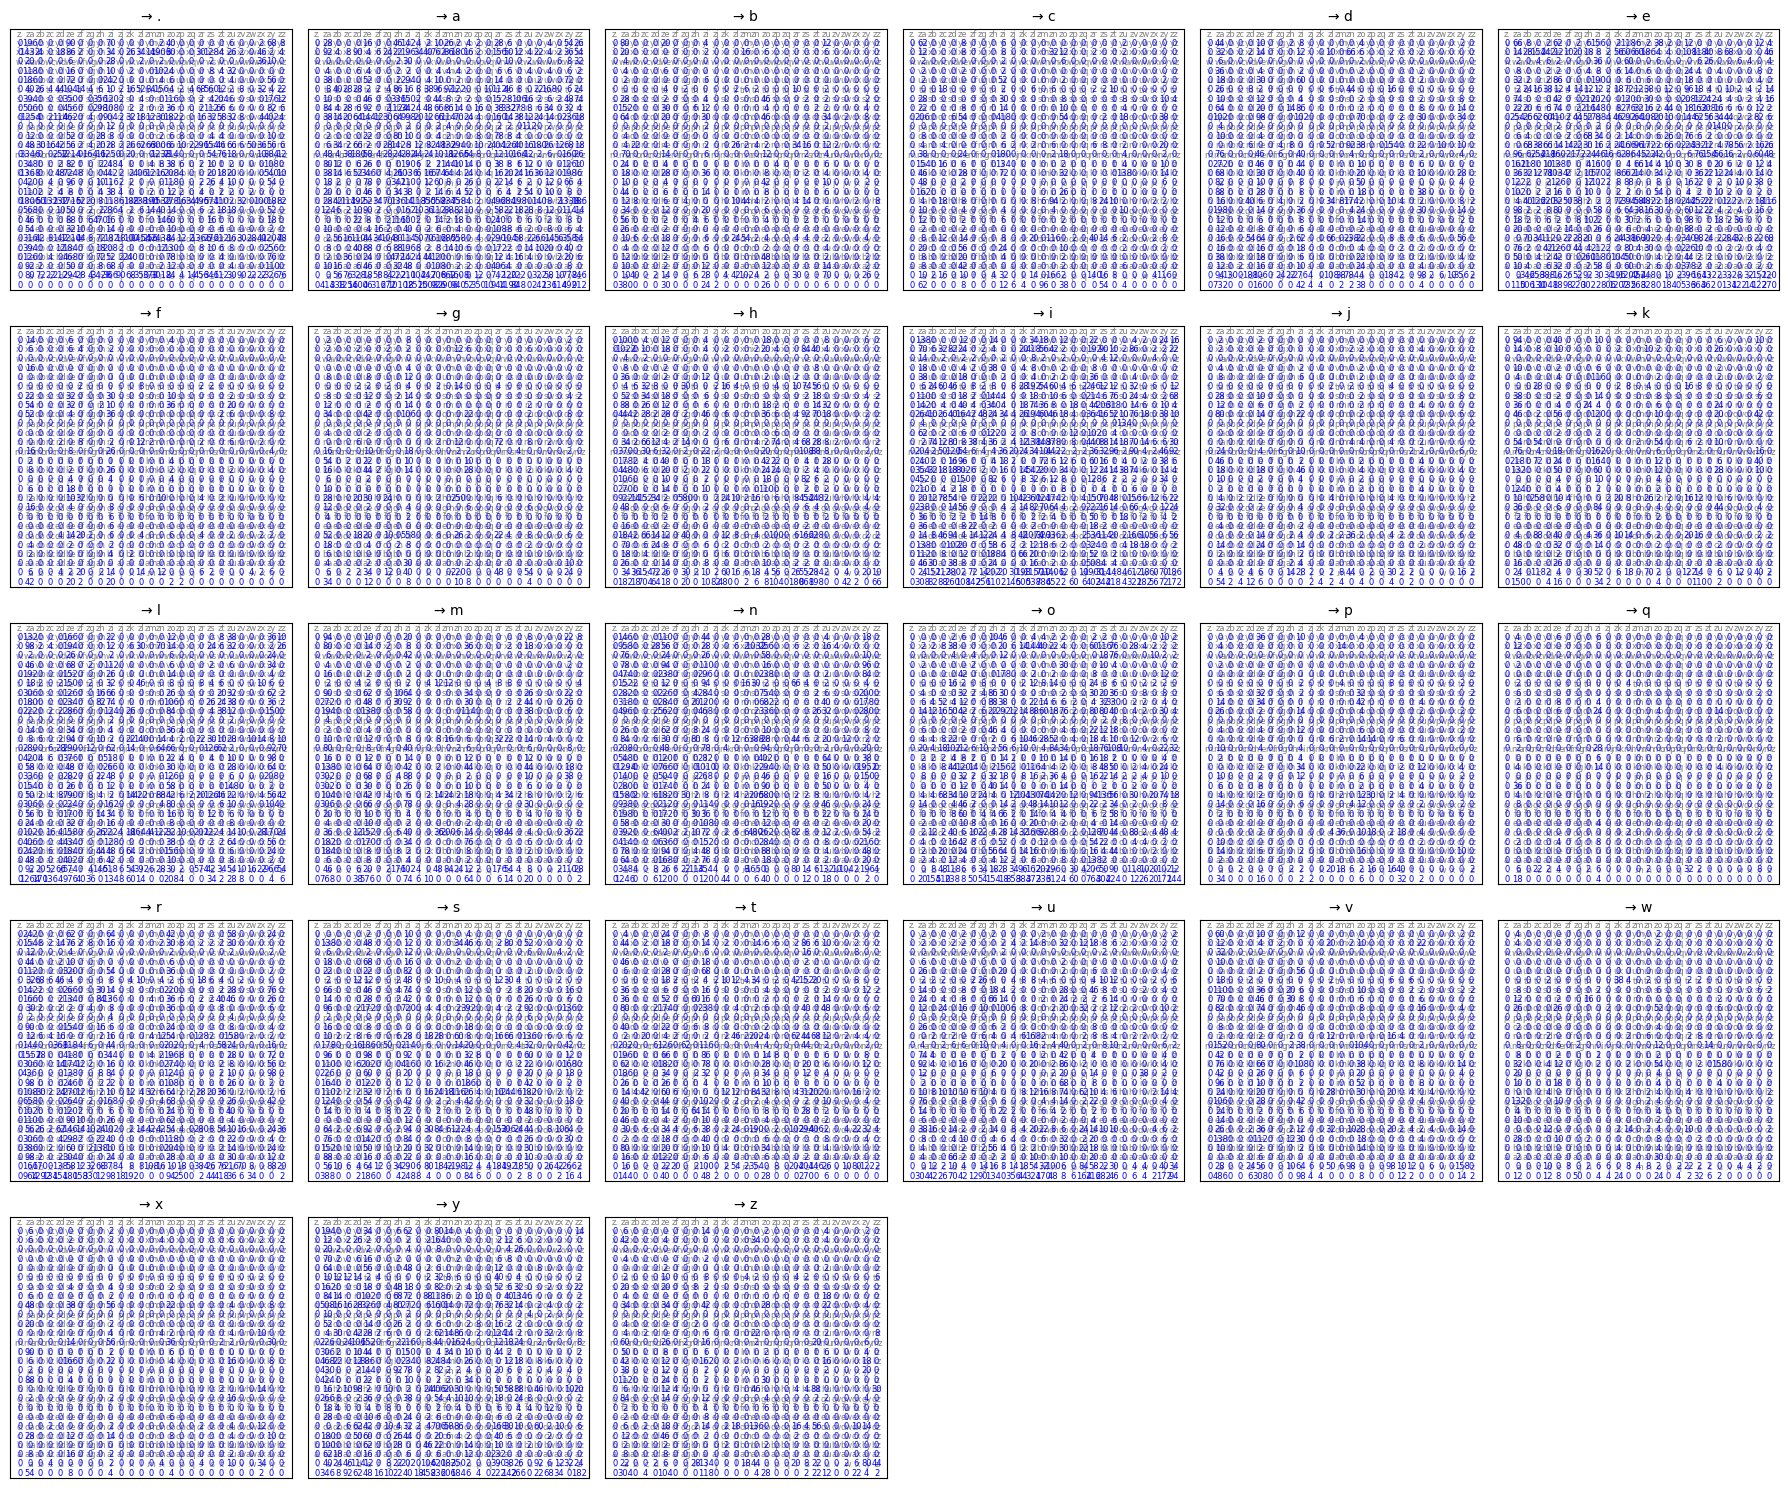

In [35]:
import matplotlib.pyplot as plt
import torch

# Each subplot shows a heatmap of bigrams (ch1+ch2) that lead to a specific character (ch3).

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(18, 15))
axes = axes.flatten()

for k in range(vocab_size):
    ax = axes[k]
    ax.set_title(f"→ {itos[k]}", fontsize=10)

    for i in range(vocab_size):
        for j in range(vocab_size):
            chstr = itos[i] + itos[j]
            count = N[i, j, k].item()
            ax.text(j, i, chstr, ha='center', va='bottom', color='gray', fontsize=6)
            ax.text(j, i, int(count), ha='center', va='top', color='blue', fontsize=6)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1, vocab_size)
    ax.set_ylim(-1, vocab_size)

# Hide unused plots
for idx in range(vocab_size, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [39]:
embedding_dim = 10
hidden_dim  = 128

# weights
embedding = torch.randn((vocab_size , embedding_dim)) # [vocab_size , embedding_dim]
w1 = torch.randn((2*embedding_dim , hidden_dim)) # [2*embedding_dim , 128] : why 2*embedding_dim --> each character has 10 emb so 2 char will have 20 to predict the 3rd character
b1 = torch.randn(hidden_dim)
w2 = torch.randn((hidden_dim , vocab_size))
b2 = torch.randn(vocab_size)

parameters = [embedding , w1 , b1 , w2 , b2]

for p in parameters:
  p.requires_grad = True

In [57]:
def build_dataset(words, stoi):
    X = []
    Y = []
    for word in words:
        # Add special start and end token '.'
        chars = ['.'] + ['.'] + list(word) + ['.']  # context size = 2
        for i in range(len(chars) - 2):
            context = chars[i:i+2]   # 2 characters
            target = chars[i+2]      # 3rd character (prediction target)
            ix = [stoi[c] for c in context]
            iy = stoi[target]
            X.append(ix)
            Y.append(iy)
    return torch.tensor(X), torch.tensor(Y)


In [97]:
# training the model
loss_fn = torch.nn.CrossEntropyLoss()

X, Y = build_dataset(words , stoi)


lr = 0.1
for epoch in range(100):
   # Mini-batching
  ix = torch.randint(0, X.shape[0], (32,))
  x_batch = X[ix]  # [B, 2]
  y_batch = Y[ix]  # [B]
  # forward pass
  emb = embedding[x_batch]
  flatten_layer = emb.view(32 , -1)
  h = torch.tanh(flatten_layer@w1 + b1)
  logits = h@w2 + b2

  # loss calculation
  loss = loss_fn(logits , y_batch)
  for p in parameters:
    p.grad = None

  loss.backward()

  # gradient descent
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.151791572570801


In [101]:
def generate_names():
  names = []
  ix1 , ix2  = stoi['.'] , stoi['.'] # initialised by starting the name

  while True:
    emb1 = embedding[ix1]
    emb2 = embedding[ix2]

    emb_cat = torch.cat([emb1 , emb2] , dim=0)
    logits = torch.tanh(emb_cat@w1+b1) @w2 +b2
    probs = torch.softmax(logits , dim=0)

    ix = torch.multinomial(probs , 1).item()

    if ix == stoi['.']:
      break

    names.append(itos[ix])
    ix1 , ix2 = ix2 , ix # we are shifting the context window forward

  return ''.join(names)




for _ in range(10):
  name  = generate_names()
  print(name)


lendmotoserrio
clannevyne
nanne
goakemenehevel
jaidy
jabenevha
kammtavian
acemilionie
aar
avio
